In [1]:
import pickle

# 读取 pickle 文件
with open('example-study.pkl', 'rb') as f:
    study = pickle.load(f)

# 现在你可以访问 study 对象中的信息，比如最优的超参数配置
print("最优参数配置:", study.best_params)

最优参数配置: {'num_blocks': 3, 'dropout': 0.14496744836895242, 'purns': 0.2070090360434076, 'lr': 5.550242519390122e-05, 'epochs': 180}


In [2]:
from datasets import load_from_disk
ind=1
item='Ames Mutagenicity'

data_dict=load_from_disk(f'dataset\cv{ind}_aug')

data_dict=data_dict.select_columns(['smiles',item])
data_dict['test']=load_from_disk('test')

train=data_dict['train'].to_pandas()
data_dict

DatasetDict({
    train: Dataset({
        features: ['smiles', 'Ames Mutagenicity', 'ids'],
        num_rows: 10719
    })
    val: Dataset({
        features: ['smiles', 'Ames Mutagenicity'],
        num_rows: 586
    })
    test: Dataset({
        features: ['smiles', 'ids', 'Ames Mutagenicity'],
        num_rows: 652
    })
})

In [3]:
import torch
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config, Trainer, TrainingArguments,GPT2DoubleHeadsModel,GPT2PreTrainedModel,GPT2ForSequenceClassification
from datasets import load_dataset

# 定义标记器和模型配置
tokenizer = GPT2Tokenizer.from_pretrained(r"D:\system\桌面\lcm-code\tokenizers_lcm\tokenizer_gpt_special.json")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id

100

In [1]:
from torch import nn
from transformers import AutoModelForSequenceClassification,GPT2ForSequenceClassification,GPT2Config
from torch.nn.utils import prune
class GPT2cls(nn.Module):
    def __init__(self,drop,purn,n_block):
        super(GPT2cls, self).__init__()
        self.config = GPT2Config.from_pretrained('D:\system\桌面\lcm-code\pre_training\chem_gpt100')  #  使用预训练的GPT2模型
        self.config.pad_token_id=tokenizer.pad_token_id
        self.config.num_labels=2
        self.config.num_attention_heads=4
        self.config.num_hidden_layers=n_block
        self.config.hidden_size=512
        self.model = AutoModelForSequenceClassification.from_config(self.config)
        for name, module in self.model.named_modules():
            if isinstance(module, (nn.Dropout, nn.Dropout2d, nn.Dropout3d)):
                module.p = drop
        for name, module in self.model.named_modules():
            if isinstance(module, torch.nn.Linear):
                prune.l1_unstructured(module, name='weight', amount=purn)
    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids,attention_mask=attention_mask)
        return outputs

model=GPT2cls(0.144,0.2,3)


NameError: name 'tokenizer' is not defined

In [5]:
tokenized_dataset = data_dict.map(
    lambda element: tokenizer(element['smiles']), batched=True
)

tokenized_dataset = tokenized_dataset.select_columns(['input_ids', 'attention_mask', item])
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'Ames Mutagenicity'],
        num_rows: 10719
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'Ames Mutagenicity'],
        num_rows: 586
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'Ames Mutagenicity'],
        num_rows: 652
    })
})

In [1]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_dataset.set_format("torch")


eval_dataloader = DataLoader(tokenized_dataset["val"], batch_size=20,collate_fn=data_collator)
test_dataloader=DataLoader(tokenized_dataset['test'],batch_size=20,collate_fn=data_collator)
train_dataloader=DataLoader(tokenized_dataset["train"], batch_size=84,collate_fn=data_collator,shuffle=True)

NameError: name 'tokenizer' is not defined

In [7]:
from torch.optim import AdamW
import torch.nn as nn
from transformers import get_scheduler


# optimizer = AdamW(model.parameters(), lr=5e-4)

criterion = nn.CrossEntropyLoss()
num_train_epochs = 200
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch
lr = 5.5e-5
optimizer = AdamW(model.parameters(), lr=lr)
lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=num_training_steps//4,
    num_training_steps=num_training_steps,
)

In [8]:
from accelerate import Accelerator
Accelerator.mixed_precision == 'fp16'
accelerator = Accelerator()

#
eval_dataloader,test_dataloader,train_dataloader,model,optimizer = accelerator.prepare(
     eval_dataloader,test_dataloader,train_dataloader,model,optimizer)
# )

In [9]:
import torch
def caculate_loss(loader,model):
    losses=[]
    model.eval()
    for batch in loader:
        with torch.no_grad():
            labels = batch[item].to(torch.int64)
            # batch['input_ids']=batch['input_ids'].to(torch.int64)
            logits = model(input_ids=batch['input_ids'],attention_mask=batch['attention_mask']).logits
            loss = criterion(logits, labels)
            losses.append(loss.unsqueeze(dim=0))
    torch.cuda.empty_cache()
    return torch.mean(torch.cat(losses,dim=0))

In [0]:
import numpy as np
def acc(loader,model):
    predicts=[]
    labels=[]
    model.eval()
    for batch in loader:
        with torch.no_grad():
            label = batch[item].to(torch.int64)
            # batch['input_ids']=batch['input_ids'].to(torch.int64)
            logits = model(input_ids=batch['input_ids'],attention_mask=batch['attention_mask']).logits

            predict=torch.argmax(logits,dim=1)
            predicts.append(predict.flatten().cpu().numpy())
            labels.append(label.flatten().cpu().numpy())

    predicts=np.concatenate(predicts)
    labels=np.concatenate(labels)
    torch.cuda.empty_cache()
    return (predicts==labels).sum()/len(labels)

  0%|          | 0/200 [00:00<?, ?it/s]

train_acc0.6316820598936468  eval_acc0.6450511945392492
train_acc0.6687190969306839  eval_acc0.6945392491467577
train_acc0.6857915850359175  eval_acc0.7047781569965871
train_acc0.6858848773206456  eval_acc0.7133105802047781
train_acc0.7095811176415711  eval_acc0.7303754266211604
train_acc0.7143390241627018  eval_acc0.726962457337884
train_acc0.7187237615449202  eval_acc0.726962457337884
train_acc0.7206828995242094  eval_acc0.726962457337884
train_acc0.7402742793171004  eval_acc0.7457337883959044
train_acc0.7432596324283982  eval_acc0.7474402730375427
train_acc0.7413004944491091  eval_acc0.7457337883959044
train_acc0.7616382125198247  eval_acc0.7662116040955631
train_acc0.7531486146095718  eval_acc0.7679180887372014
train_acc0.7771247317846814  eval_acc0.764505119453925
train_acc0.7725534098330068  eval_acc0.7849829351535836
train_acc0.7862673756880306  eval_acc0.7781569965870307
train_acc0.7980222035637653  eval_acc0.7849829351535836
train_acc0.8107099542867805  eval_acc0.7918088737201

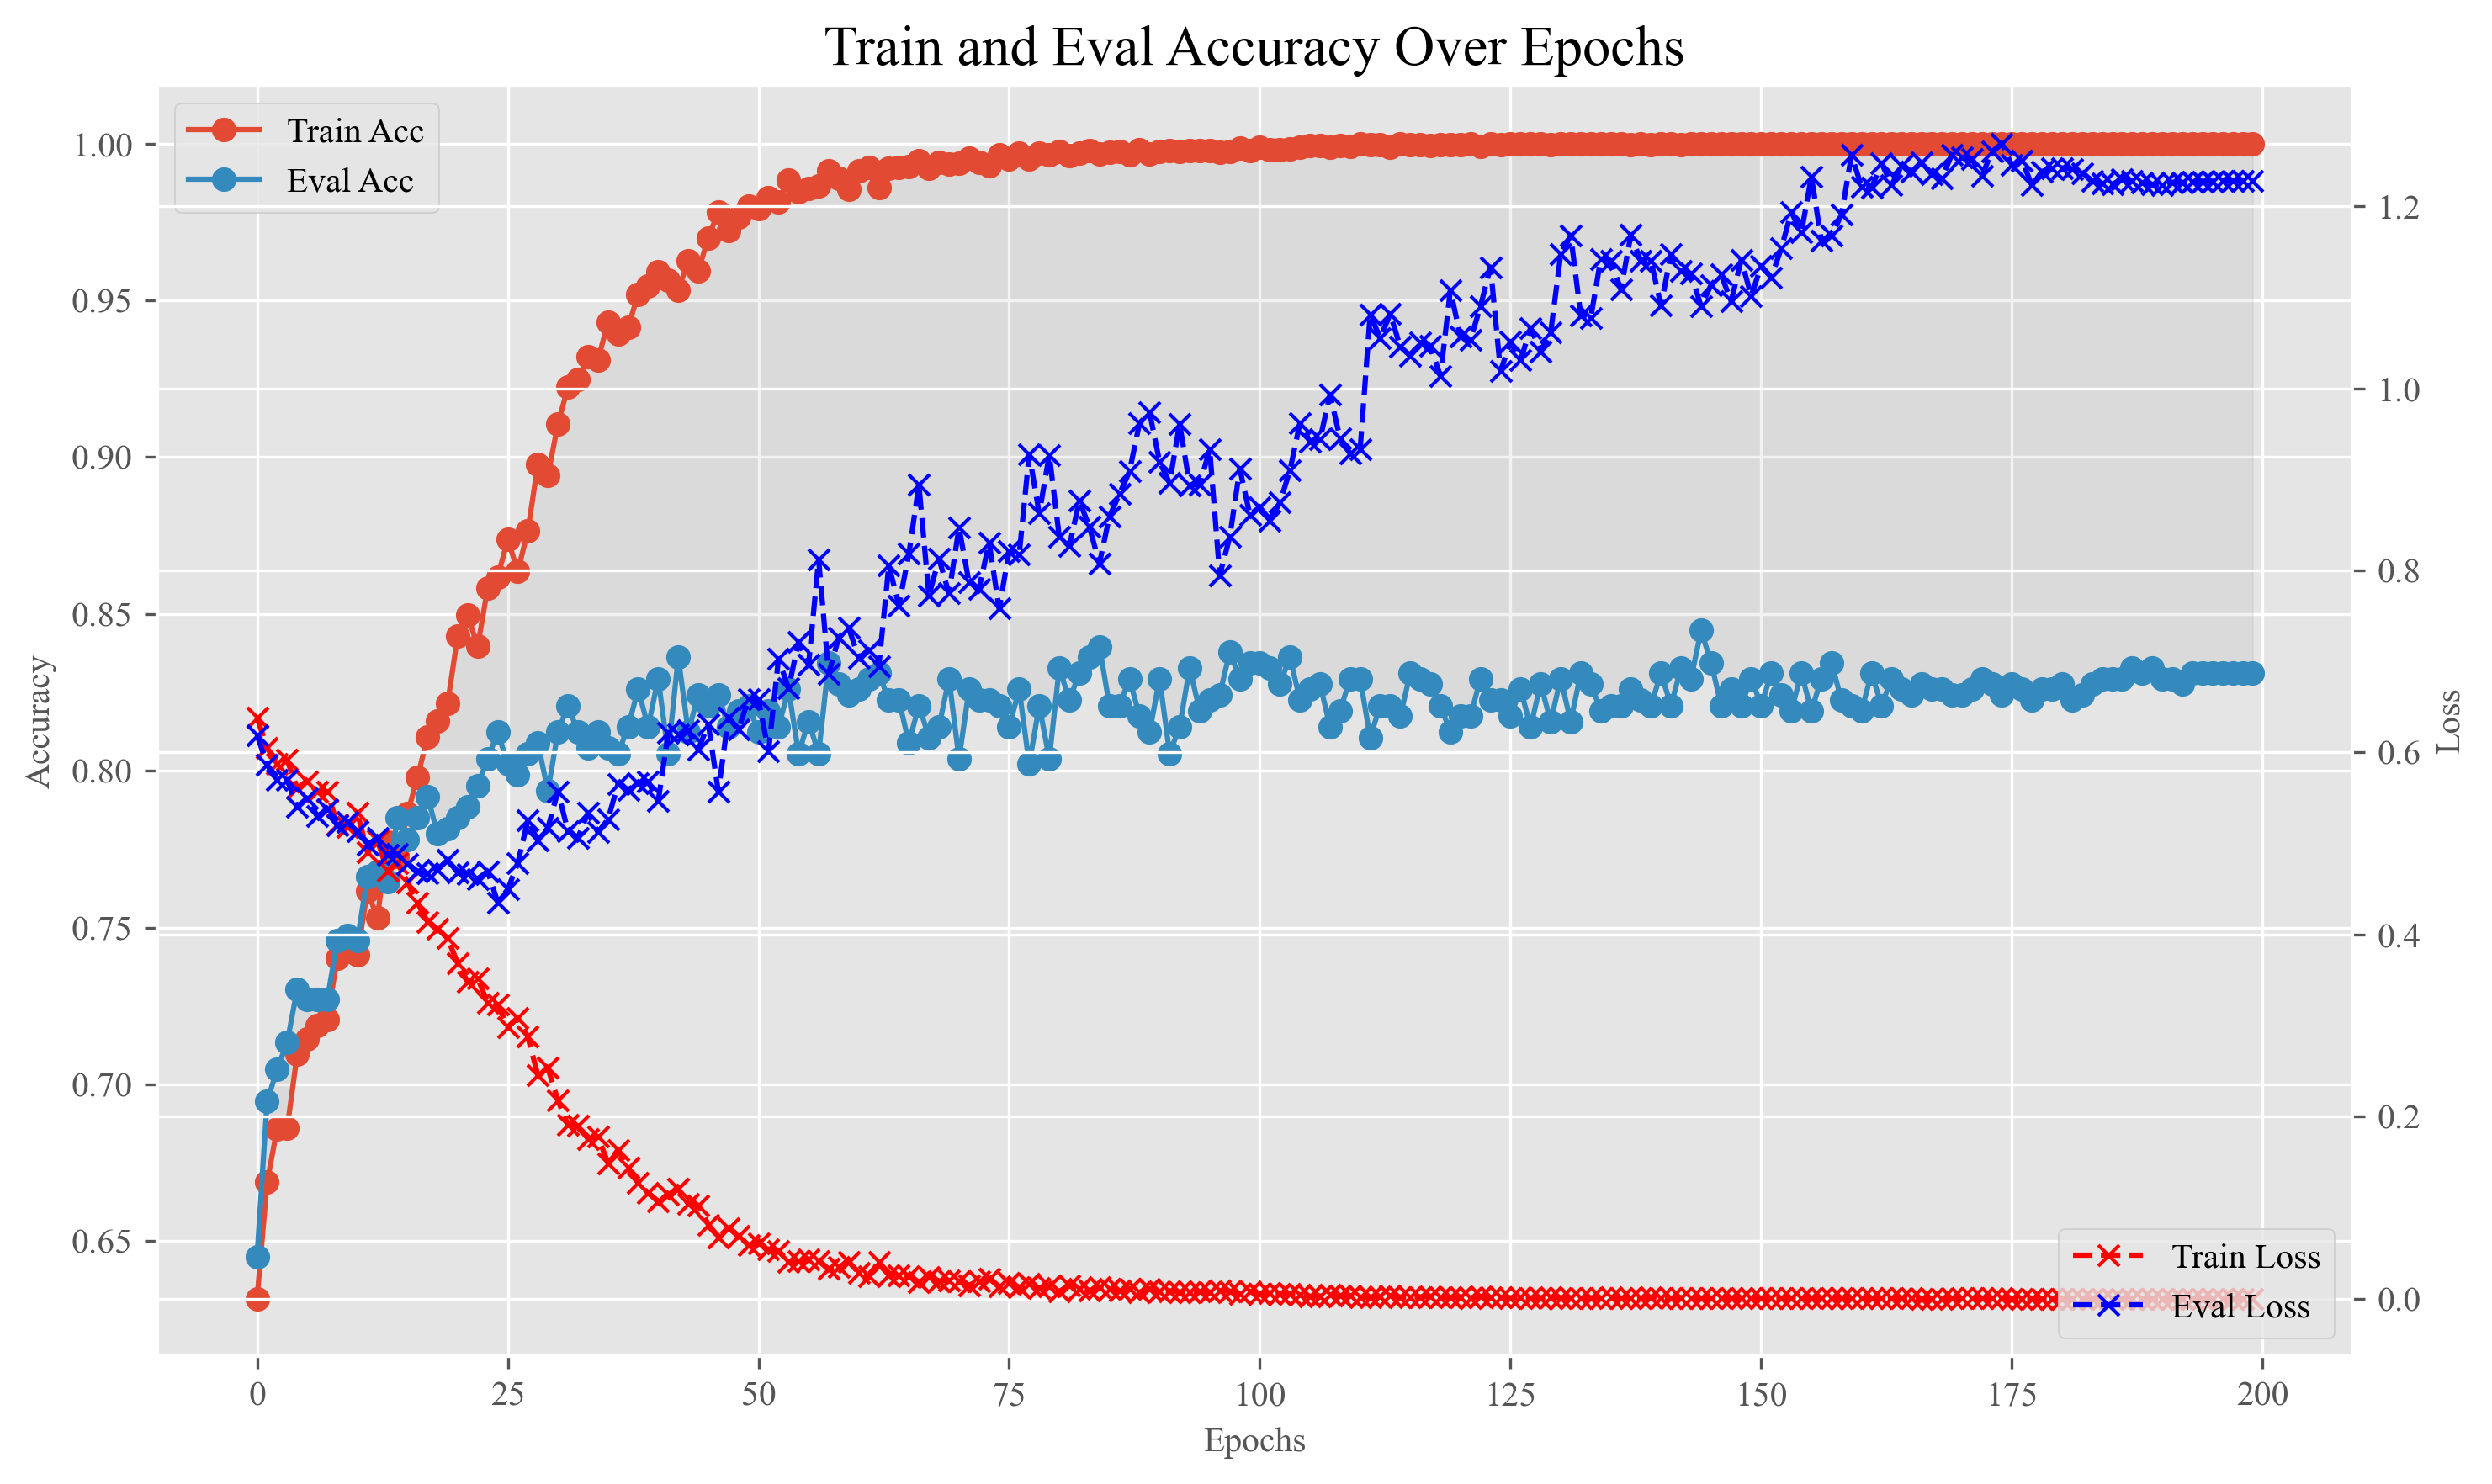

In [11]:
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from collections import defaultdict
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'
# Generate the optimizers.

best_acc = 0
completed_steps = 1

train_accs=[]
eval_accs=[]
train_losses=[]
eval_losses=[]
best_accs=[]
best_models=[]
for epoch in tqdm(range(num_train_epochs),total=num_train_epochs):

    model.train()
    for step,batch in enumerate(train_dataloader):

        labels = batch[item].to(torch.int64)

        logits = model(input_ids=batch['input_ids'],attention_mask=batch['attention_mask']).logits


        loss = criterion(logits, labels)

        accelerator.backward(loss)

        # accelerator.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        completed_steps += 1
        torch.cuda.empty_cache()


    eval_acc=acc(eval_dataloader,model)
    train_acc=acc(train_dataloader,model)
    train_accs.append(train_acc)
    eval_accs.append(eval_acc)

    train_losse=caculate_loss(train_dataloader,model)
    eval_losse=caculate_loss(eval_dataloader,model)
    train_losses.append(train_losse.cpu().numpy())
    eval_losses.append(eval_losse.cpu().numpy())

    tqdm.write(f'train_acc{train_acc}  eval_acc{eval_acc}')
    torch.cuda.empty_cache()

    if len(best_models) < 3 or eval_acc > max(best_accs):
        best_models.append(model.state_dict())
        best_accs.append(eval_acc)

    # 如果保存的模型数量超过了5个，则删除验证集损失最大的模型
    if len(best_models) > 3:
        min_acc_idx = best_accs.index(min(best_accs))
        del best_models[min_acc_idx]
        del best_accs[min_acc_idx]

    if eval_acc > best_acc:
        torch.save(model.state_dict(), 'best_val.model')
        best_acc = eval_acc

fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制 accuracy
ax1.plot(range(num_train_epochs), train_accs, label='Train Acc', marker='o')
ax1.plot(range(num_train_epochs), eval_accs, label='Eval Acc', marker='o')
ax1.fill_between(range(num_train_epochs), train_accs, eval_accs, color='gray', alpha=0.1)
ax1.set_xlabel('Epochs', fontsize=10)
ax1.set_ylabel('Accuracy', fontsize=10)
ax1.set_title('Train and Eval Accuracy Over Epochs', fontsize=16)
ax1.legend(loc='upper left', fontsize=10)

# 创建第二个 y 轴并绘制 loss
ax2 = ax1.twinx()
ax2.plot(range(num_train_epochs), train_losses, label='Train Loss', color='red', linestyle='--', marker='x')
ax2.plot(range(num_train_epochs), eval_losses, label='Eval Loss', color='blue', linestyle='--', marker='x')
ax2.set_ylabel('Loss', fontsize=10)
ax2.legend(loc='lower right', fontsize=10)

plt.grid(True)
plt.tight_layout()
plt.gcf().set_dpi(300)
plt.show()



